In [62]:
import json, os
import networkx as nx
import itertools

In [51]:
# '1a-basic-flow'
# '1b-basic-flow'
# '2-expr-binary-ops'
# '3a-expr-func-calls'

TEST_SlICE = '2-expr-binary-ops'

In [52]:
with open(os.path.join('testSlices', TEST_SlICE + '.json')) as json_file:
    slices = json.load(json_file)

with open(os.path.join('testPatterns', TEST_SlICE + '.patterns.json')) as json_file:
    patterns = json.load(json_file)

Initialize Classes

In [54]:
class Stmt_Expression():
    def __init__(self, expr):
        self.expr = expr
    
    def __repr__(self):
        return f"Stmt_Expression({self.expr})"

class Expr_Assign():
    def __init__(self, var, list_expr):
        self.var = var
        self.list_expr = list_expr
    def __repr__(self):
        str_list_expr = ", ".join(str(expr) for expr in self.list_expr)
        return f"{self.var} = {str_list_expr}"
        #return f"Assignment({self.var}={self.expr})"

class Expr_FuncCall():
    def __init__(self, name, args=[]):
        self.name = name
        self.args = args
    def __str__(self):
        str_args = ", ".join(str(arg) for arg in self.args)
        return f"{self.name}({str_args})"
    def __repr__(self):
        return f"{self.name}()"
        #return f"FuncCall(name={self.name},args={self.args})"

class Expr_Variable():
    def __init__(self, name):
        self.name = name
    def __repr__(self):
        return f"${self.name}"
        #return f"Variable({self.name})"
    #def __eq__(self, other):
        # Check if the other object is an Assignment and has the same left and right values
    #    if isinstance(other, Expr_Variable) and self.name == other.name:
    #        return True
    #    return False
    #def __hash__(self):
        # Return a unique and immutable value based on the left and right values
    #    return hash(self.name)

class Constant():
    def __init__(self, value):
        self.value = value
    def __repr__(self):
        return f"Constant(value={self.value})"

class Expr_BinaryOp_Concat():
    def __init__(self, left, right):
        self.left = left
        self.right = right
    def __repr__(self):
        return f"{self.left}, {self.right}"

class Program():
    def __init__(self, steps):
        self.steps = steps
    def __repr__(self):
        str_steps = '\n'.join(f'\t{idx}. {step}' for idx, step in enumerate(self.steps))
        return f'Program(\n{str_steps}\n)'

Recusive Function to convert the input slices into class objects

In [55]:
def flatten(lst):
    flat_list = []
    for item in lst:
        if isinstance(item, list):
            flat_list.extend(flatten(item))
        else:
            flat_list.append(item)
    return flat_list
    
def process_json(obj):
    if isinstance(obj, dict):
        if obj["nodeType"] == 'Stmt_Expression':
            #expr = process_json(obj["expr"])
            #return Stmt_Expression(expr)
            return process_json(obj["expr"])
        if obj["nodeType"] == "Expr_Assign":
            var = process_json(obj["var"])
            list_expr = [process_json(obj["expr"])]
            return Expr_Assign(var, list_expr)
        if obj["nodeType"] == "Expr_FuncCall":
            name = obj["name"]["parts"][0]
            args = flatten([process_json(arg) for arg in obj["args"]])
            return Expr_FuncCall(name, args)
        if obj["nodeType"] == "Expr_BinaryOp_Concat":
            left = process_json(obj["left"])
            right = process_json(obj["right"])
            return flatten([left, right])
        if obj["nodeType"] == "Arg":
            return process_json(obj["value"])
        if obj["nodeType"] == "Expr_Variable":
            return Expr_Variable(obj["name"])
        if obj["nodeType"] == "Scalar_String":
            return Constant(obj["value"])
    elif isinstance(obj, list):
        #for item in obj:
        steps = [process_json(step) for step in obj][:-1]
        return Program(steps)
    else:
        # this is for error catching :)
        print(obj)

# Process the JSON object
parsed_ast = process_json(slices)

Print the program in a readable format

In [56]:
print(parsed_ast)

Program(
	0. $a = b()
	1. $c = s(Constant(value=ola), $a)
	2. $f = e($c, Constant(value=oi), $d, Constant(value=hi), $a)
)


Recusively create a graph based on the program

In [73]:
class ASTgraph:
    def __init__(self):
        self.nodes = []
        self.edges = []

    def add_node(self,node):
        self.nodes.append(node)
        
    def remove_node(self,node):
        self.nodes.remove(node)

    def add_edge(self,firstNode, secondNode):
        if firstNode not in self.nodes:
            self.nodes.append(firstNode)
        if secondNode not in self.nodes:
            self.nodes.append(secondNode)
        self.edges.append((firstNode,secondNode))

    def remove_edge(self, firstNode, secondNode):
        self.edges.remove((firstNode, secondNode))

    def has_node(self, node):
        return node in self.nodes

    def in_edges(self, node):
        edgesFound = []
        for edge in self.edges:
            if node in edge:
                edgesFound.append(edge)
        return edgesFound

    def successors(self,node):
        successors = []
        for pair in self.edges:
            if pair[0] == node:
                successors.append(pair[1])
        return successors




In [74]:
##Test graph
testGraph = ASTgraph()

testGraph.add_edge(1,2)
testGraph.add_edge(3,1)
testGraph.add_edge(4,5)
testGraph.add_edge(1,5)

testGraph.remove_edge(3,1)



print(testGraph.nodes)
print(testGraph.edges)
print(testGraph.successors(1))
print(testGraph.in_edges(1))



[1, 2, 3, 4, 5]
[(1, 2), (4, 5), (1, 5)]
[2, 5]
[(1, 2), (1, 5)]


In [79]:
# Function to recursively find all assignments in the AST
def create_graph(node, graph):
    if isinstance(node, Expr_Assign):
        if graph.has_node(str(node.var)):
            # If the value of a varaible is overwritten before it is referenced anywhere
            if len(list(graph.successors(str(node.var)))) == 0:
                for u, v in list(graph.in_edges(str(node.var))):
                    graph.remove_edge(u, v)
                    graph.remove_node(u)
        for expr in node.list_expr:
            if isinstance(expr, Expr_FuncCall):
                graph.add_edge(repr(expr), str(node.var))
                create_graph(expr, graph)
            if isinstance(expr, Expr_Variable):
                graph.add_edge(str(expr), str(node.var))
    if isinstance(node, Expr_FuncCall):
        for arg in node.args:
            graph.add_edge(str(arg), repr(node))
    if hasattr(node, 'steps'):
        for step in node.steps:
            create_graph(step, graph)

# Create an empty graph
graph = nx.DiGraph()

# Find all assignments in the AST and add them to the graph
create_graph(parsed_ast, graph)

Print the graph

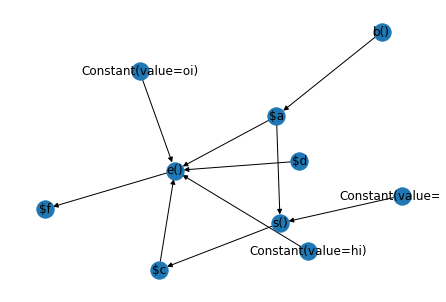

In [8]:
# Use NetworkX's draw() function to draw the graph
nx.draw(graph, with_labels=True)

# Display the graph
plt.show()

In [80]:
def get_following_nodes(graph, node):
    following_nodes = []
    stack = [node]
    visited = set()
    while stack:
        current_node = stack.pop()
        if current_node not in visited:
            visited.add(current_node)
            if current_node != node:
                following_nodes.append(current_node)
            stack.extend(graph.successors(current_node))
    return following_nodes

def get_paths(graph, start, path=[]):
    path = path + [start]
    if start not in graph.nodes:
        return []
    paths = []
    for node in graph.successors(start):
        new_paths = get_paths(graph, node, path)
        for new_path in new_paths:
            paths.append(new_path)
    if not paths:
        paths.append(path)
    return paths

def create_output_list(list_output: list, new_vulnerability: json) -> list:
    EXISTS = False
    for idx, known_vulnerability in enumerate(list_output):
        if all(known_vulnerability[key] == new_vulnerability[key] for key in ["vulnerability", "source", "sink"]):
            EXISTS = True
            if len(new_vulnerability["sanitized flows"]) == 0:
                list_output[idx]["unsanitized flows"] = "yes"
            else:
                list_output[idx]["sanitized flows"].append(new_vulnerability["sanitized flows"])
    if not EXISTS:
        list_output.append(new_vulnerability)
    return list_output
    
def analyze_patterns(pattern: dict, graph: ASTgraph) -> dict:
    list_output = []
    for source in pattern["sources"]:
        if "$" not in source: # FIXME: Maybe remove this from the graph 
            source += "()"
        possible_paths = get_paths(graph, source)
        for sink in pattern["sinks"]:
            if "$" not in sink:
                sink += "()"
            for path in possible_paths:
                if sink in path:
                    if pattern["implicit"] == 'yes' or (pattern["implicit"] == 'no' and path.index(sink) > 0):
                        sanitizers = []
                        for sanitize_func in pattern["sanitizers"]:
                            if sanitize_func + "()" in path:
                                if path.index(sanitize_func + "()") < path.index(sink):
                                    sanitizers.append(sanitize_func + "()")
                        
                        list_output = create_output_list(
                            list_output = list_output, 
                            new_vulnerability = {
                                "vulnerability": pattern["vulnerability"],
                                "source": source,
                                "sink": sink,
                                "unsanitized flows": "yes" if len(sanitizers) == 0 else "no",
                                "sanitized flows": sanitizers
                            }
                        )
                        

    return list_output

In [81]:
output = []
for pattern in patterns:
    output.extend(analyze_patterns(pattern, graph))
output

[{'vulnerability': 'A',
  'source': '$a',
  'sink': 'e()',
  'unsanitized flows': 'yes',
  'sanitized flows': []},
 {'vulnerability': 'B',
  'source': 'b()',
  'sink': '$a',
  'unsanitized flows': 'yes',
  'sanitized flows': []},
 {'vulnerability': 'B',
  'source': 'b()',
  'sink': 'e()',
  'unsanitized flows': 'yes',
  'sanitized flows': ['s()']}]